## Prepare evironment

In [2]:
!pip install keras-tcn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/Studium/Semester_Project/Tflite

Mounted at /content/drive
/content/drive/My Drive/Studium/Semester_Project/Tflite


In [4]:
import numpy as np
import tensorflow as tf
import time
import pandas as pd
import os
import json
from pathlib import Path
from keras.utils import to_categorical
import argparse
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
import time
from tcn import TCN
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as mse


print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.12.0


## Helper Functions

In [5]:
def generate_json_file(data, filename):
    with open(filename, 'w') as file:
        json.dump(data, file)

In [6]:
def plot_predictions_detailed(y_true, y_pred, model_path, description, show_plot):
    if not os.path.exists(Path(model_path, description)):
      os.mkdir(Path(model_path, description))

    assert len(y_true)==len(y_pred)
    print("Plot " + description.replace("_", " "))
    plt.yscale('log')
    plt.plot(abs(y_true), label="True IRT")
    plt.plot(abs(y_pred), label="Predicted IRT")
    plt.xlabel("Request index (no unit)")
    plt.ylabel("Absolute Inter Request Time [s]")
    plt.title(description.replace("_", " "))
    plt.legend()
    plt.savefig(Path(model_path, description ,description+".png"))
    if show_plot:
        plt.show()
    plt.close()

    np.save(Path(model_path, description,'y_true.npy'), y_true)
    np.save(Path(model_path, description,'y_pred.npy'), y_pred)

    # plot different parts of the trace and the corresponding MSE
    l = len(y_true)
    plt_range = min(70, l // 3 - 1)

    # define appropriate locations for plotting: highest irt, lowest irt, random
    idx_high_irt = [np.argmax(y_true[plt_range // 2:l // 3]) + plt_range // 2,
                    # since only idx after plt_range/2 are considered, resulting idx has to be corrected
                    np.argmax(y_true[l // 3:2 * l // 3]) + l // 3,
                    np.argmax(y_true[2 * l // 3:l - plt_range // 2]) + 2 * l // 3]
    idx_low_irt = [np.argmin(y_true[plt_range // 2:l // 3]) + plt_range // 2,
                   np.argmin(y_true[l // 3:2 * l // 3]) + l // 3,
                   np.argmin(y_true[2 * l // 3:l - plt_range // 2]) + 2 * l // 3]
    idx_random_irt = list(np.random.randint(plt_range // 2, l - plt_range // 2 - 1, size=3))
    idx = [idx_high_irt, idx_low_irt, idx_random_irt]

    fig = plt.figure(constrained_layout=True)
    fig.suptitle(description.replace("_", " ")+": Predicted IRT=Orange, True IRT=Blue")
    fig.set_size_inches(24, 14)
    row_title = ["High inter request time", "Low inter request", "Random"]
    # create 3x1 subfigs
    subfigs = fig.subfigures(nrows=3, ncols=1)
    for row, (subfig, idx_row) in enumerate(zip(subfigs, idx)):
        subfig.suptitle(f'{row_title[row]}')
        # create 1x3 subplots per subfig
        axs = subfig.subplots(nrows=1, ncols=3)
        for col, (ax, idx) in enumerate(zip(axs, idx_row)):
            begin = idx - plt_range // 2
            end = idx + plt_range // 2
            x_ = range(begin, end)
            y_t = y_true[begin:end]
            y_p = y_pred[begin:end]
            ax.plot(x_, y_t, label="true", color='blue')
            ax.plot(x_, y_p, label="pred", color="orange")
            ax.set_xlabel("Request index (no unit)")
            ax.set_ylabel("Inter Request Time [s]")
            ax.set_title(f'MSE {np.square(np.subtract(y_t, y_p)).sum()}')
            np.save(Path(model_path, description, str(row*3+col)+'_idx.npy'), np.array([begin,end]))
    fig.savefig(Path(model_path, description,description+"eval.png"))
    if show_plot:
        plt.show()
    plt.close()

In [7]:
class Namespace:
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)

args = Namespace(description = 'tflite', workload_item = 'generated',
                 workload = "ycsb", n_trials = 1, take_best_model = True,
                 log_irt = True, evaluate = False, load_model = False)
with open(Path('args.json'), 'w') as f:
        json.dump(vars(args), f)

In [8]:
def df_get_one_hot(df, col_name, prefix):
    nof_cols= df.shape[1]
    nof_new_cols = len(df[col_name].unique())
    df_op = pd.get_dummies(df[col_name], prefix=prefix, dtype=int)
    df.drop([col_name], axis=1, inplace=True)
    df = pd.concat([df_op, df], axis=1)
    assert nof_cols + nof_new_cols -1 == df.shape[1]
    return df

def load_workload(args, n_past, batch_size, df_part, folder_path):

    try:
        with open(Path(folder_path, "params.json")) as f:
            s = json.load(f)
    except:
        print("Try to find params.json in ....")
        with open(Path("params.json")) as f:
            s = json.load(f)

    path= Path(s["paths"]["df_prefix_loc"])
    path=Path(path,s["paths"][args.workload][args.workload_item])

    df = pd.read_csv(Path(path))
    df_train, df_test, trainX, trainY, testX, testY, scaler = preprocess(df, folder_path, s, args.log_irt, n_past, batch_size, df_part, args.workload)
    return df_train, df_test, trainX, trainY, testX, testY, scaler

def preprocess(df, folder_path, settings, log_irt, n_past, batch_size, df_part, workload):
    # Choose features for training
    if "ycsb" in str(workload):
        cols = settings["df_shape"]["features_ycsb_exclude"]
    else:
        cols = settings["df_shape"]["features_msr_cambridge_exclude"]

    if "CPU_" in df.columns.any():
        try:
            cols.remove("CPU Core ID")
        except:
            pass

        if "ProcessID" not in cols:
            cols.append("ProcessID")

    elif "PID_" in df.columns.any():
        try:
            cols.remove("ProcessID")
        except:
            pass

        if "CPU Core ID" not in cols:
            cols.append("CPU Core ID")

    else:
        if "ProcessID" in df.columns:
            cols.append("ProcessID")
        if "CPU Core ID" in df.columns:
            cols.append("CPU Core ID")

    if "ProcessID" in cols:
        pid_columns = [col for col in df.columns if col.startswith("PID_")]
        df.drop(pid_columns, axis=1, inplace=True)

    if "CPU Core ID" in cols:
        pid_columns = [col for col in df.columns if col.startswith("CPU_")]
        df.drop(pid_columns, axis=1, inplace=True)

    irt_future = df.iloc[1:]["inter request time (s)"]
    irt_future.reset_index(drop=True, inplace=True)
    df = df.head(-2)
    df.reset_index(drop=True, inplace=True)
    df["future inter request time (s)"] = irt_future

    # New dataframe with only training data
    df_mod = df
    for col in cols:
        try:
            df_mod.drop([col], axis=1, inplace=True)
        except:
            pass
    #print(str(df_mod.columns))

    # replace read and write with integer numbers
    df_mod.replace("W", "Write", inplace=True)
    df_mod.replace("WM", "Write", inplace=True)
    df_mod.replace("R", "Read", inplace=True)
    df_mod.replace("RSM", "Read", inplace=True)

    # substitute neg SSD Processing time
    if "SSD processing time (s)" in str(cols):
        neg_ssd_time_idx = df_mod[df_mod["SSD processing time (s)"] < 0].index.values
        df_mod_R = df_mod[df_mod["OperationType"] == "Write"]
        df_mod_W = df_mod[df_mod["OperationType"] == "Read"]

        for i in neg_ssd_time_idx:
            if df_mod.iloc[i]["OperationType"] == 0:
                t = df_mod_R[df_mod_R.index < i].iloc[-1]["SSD processing time (s)"]
            else:
                t = df_mod_W[df_mod_W.index < i].iloc[-1]["SSD processing time (s)"]
            df_mod.loc[i, "SSD processing time (s)"] = t

    #One Hot encoding of categorical variables
    df_mod = df_get_one_hot(df_mod, col_name="OperationType", prefix="Op") #
    cols = df_mod.columns

    if log_irt:  # if the log is taken from irt, all entries with 0 must be replaced
        df_mod["inter request time (s)"].replace(0, 1e-9, inplace=True)
        df_mod["future inter request time (s)"].replace(0, 1e-9, inplace=True)
        df_mod['future inter request time (s)'] = np.log(df_mod['future inter request time (s)'])
        df_mod['inter request time (s)'] = np.log(df_mod['inter request time (s)'])

    # check if future idle time is right
    for i in np.random.randint(0, len(df_mod) - 1, size=10):
        assert df_mod.iloc[i]["future inter request time (s)"] == df_mod.iloc[i + 1]["inter request time (s)"]

    #check if target label is the last column
    assert df_mod.columns[-1] == "future inter request time (s)"

    #limit length of dataset
    df_mod = df_mod[df_part[0]:min(len(df_mod), df_part[1])]

    # split into train and test sets
    n_future = settings["df_shape"]["n_future"]  # Number of timestamps to look into the future based on the past timestamps.
    train_test_split = settings["df_shape"]["train_test_split"]
    train_size = (int(len(df_mod) * train_test_split - n_past) // (10 * batch_size)) * (
                10 * batch_size) + n_past  # make sure the train_size is divisible by the batchsize even after validation split
    test_size = ((len(df_mod) - train_size - n_past) // batch_size) * batch_size + n_past
    train, test = df_mod[0:train_size], df_mod[train_size:train_size + test_size]
    print(f" Train set size: {train_size} \n Test set size: {test_size}")

    # feature and target label generation
    trainX, trainY, scaler = get_time_series_shape1([train, train_size, n_past, n_future])
    testX, testY, scaler = get_time_series_shape1([test, test_size, n_past, n_future, settings, scaler])

    # Xshape = [setsize,npast,featureset]
    # Yshape = [setsize,1]
    # check if the featureset from the current timestamp is in the featureset of the next timestamp on the index "index" before,
    # since this featureset becomes older (older featureset are more on top than newer ones)
    assert np.array_equal(trainX[2, 2], trainX[3, 1])
    assert np.array_equal(testX[2, 2], testX[3, 1])
    assert np.array_equal(trainX[-2, 2], trainX[-1, 1])
    assert np.array_equal(testX[-2, 2], testX[-1, 1])
    # check if the prediction of one timestamp is in the featureset of the next timestamp on the bottom.
    irt_idx = df_mod.columns.get_loc("inter request time (s)")
    assert np.array_equal(trainY[3][0], trainX[4,-1,irt_idx])
    assert np.array_equal(testY[3][0], testX[4,-1,irt_idx])
    assert np.array_equal(trainY[-2][0], trainX[-1,-1,irt_idx])
    assert np.array_equal(testY[-2][0], testX[-1,-1,irt_idx])

    # check if transformation is made right (check first 20 entries)
    if log_irt:
        assert np.equal(np.round(np.exp(inverse_scale(scaler, trainY))[1:20], 13),
                        np.round(np.exp(train.iloc[n_past-1:]["future inter request time (s)"]).values[1:20], 13)).all()
    else:
        assert np.equal(np.round(inverse_scale(scaler, trainY)[1:20], 13),
                        np.round(train.iloc[n_past-1:]["future inter request time (s)"].values[1:20], 13)).all()

    try:
        if settings["hyperparam"]["tcn"]["classify"] == 1:
            print("### Classifier ####")
            trainY = to_categorical(trainY, len(train["future inter request time (s)"].unique()))
            testY = to_categorical(testY, len(train["future inter request time (s)"].unique()))
    except:
        pass

    return train, test, trainX, trainY, testX, testY, scaler

def get_time_series_shape1(*args):
    # either the trainset or the test is given as input.
    # given the trainset, the scaler is generated.
    # given the testset, the scaler is an additional input

    dataset = args[0][0]
    size = args[0][1]
    n_past = args[0][2]
    n_future = args[0][3]

    # scaling
    if len(args[0]) == 4:
        scaler = MinMaxScaler(feature_range=(-1, 1))  # QuantileTransformer()
        scaler = scaler.fit(dataset.values)
    else:
        scaler = args[0][5]

    preset = scaler.transform(dataset)

    # As required for LSTM networks,  reshape an input data into n_samples x timesteps x n_features.
    # Empty lists to be populated using formatted training data
    X = []
    Y = []

    # Reformat input data into a shape: (n_samples x timesteps x n_features)
    for i in range(n_past, size - n_future + 1):
        X.append(preset[i - n_past:i, :-1])
        Y.append(preset[i - 1:i, -1])

    X, Y = np.array(X), np.array(Y)

    print('X shape == {}.'.format(X.shape))
    print('Y shape == {}.'.format(Y.shape))
    return X, Y, scaler

def inverse_scale(scaler, data):
    #data = data.reshape(-1,1)
    prediction_copies = np.repeat(data, scaler.data_range_.shape[0], axis=-1)
    return scaler.inverse_transform(prediction_copies)[:, -1]

In [9]:
def custom_loss(alpha):
    def loss_fn(y_true, y_pred):
        beta = 1.0  # Weight for penalizing too low predictions
        error = y_pred - y_true
        loss = tf.where(error < 0, alpha * tf.abs(error), beta * tf.abs(error))
        return tf.reduce_mean(loss)
    return loss_fn

## Define Parameters
Note: Note all parameters in params.json are actually used in this script.

In [10]:
data = {
  "paths":{
    "df_prefix_loc": "../Workloads/",
    "dest_prefix_loc": "../Models/LSTM/",
    "msr-cambridge": {
      "sample": "MSR-Cambridge/msr_cambridge_mod2_it.csv",
      "lvm0": "MSR-Cambridge/Parts_mod_it/CAM-USP-01-lvm0_mod_it.csv",
      "hm0": "MSR-Cambridge/Parts_mod_it/CAMRESHMSA01-lvm0-1_mod_it.csv",
      "regular": "MSR-Cambridge/Parts_mod_it/CAM-02-SRV-lvm1-12_mod_it.csv",
      "very_simple":"MSR-Cambridge/Parts_mod_it/CAM-02-SRV-lvm1-12_very_simple.csv",
      "classify": "MSR-Cambridge/Parts_mod_it/CAM-02-SRV-lvm1-12_classwise.csv"
    },
    "ycsb": {
      "sample": "YCSB/YCSB-25_sample_mod.csv",
      "ssdtrace-00": "YCSB/ssdtrace-00_short_mod_it.csv",
      "ssdtrace-25": "YCSB/ssdtrace-25-73_mod_it.csv",
      "generated": "YCSB/generated_mod_it.csv",
      "ssdtrace-00_pid": "YCSB/ssdtrace-00_short_mod_pid_it.csv",
      "ssdtrace-25_pid": "YCSB/ssdtrace-25-73_mod_pid_it.csv",
      "generated_pid": "YCSB/generated_mod_pid_it.csv",
      "ssdtrace-00_cpu": "YCSB/ssdtrace-00_short_mod_cpu_it.csv",
      "ssdtrace-25_cpu": "YCSB/ssdtrace-25-73_mod_cpu_it.csv",
      "generated_cpu": "YCSB/generated_mod_cpu_it.csv"
    }
  },

  "df_part": [0,100000],
  "folder_path_model": "../Models/Final/LSTM/Regular",

  "df_shape": {
    "n_future":1,
    "train_test_split": 0.4,
    "features_msr_cambridge_exclude":["timestamp (s)", "idle time (s)", "SectorNumber", "response_time"],
    "features_ycsb_exclude": ["SectorNumber", "timestamp (s)", "idle time (s)"]
  },

  "earlystop": {
    "min_delta": 1e-4,
    "patience": 30
  },

  "hyperparam": {
    "lstm": {
      "enable": 1,
      "stateful": "True",
      "n1": [160,160,160],
      "n2": [256,256,256],
      "n3": [128,128,128],
      "activation": ["tanh"],
      "recurrent_activation": ["relu"]
      },

    "tcn":{
      "enable": 0,
      "classify": 0,
      "nb_filters": [160, 160, 160],
      "kernel_size": [3, 3, 3],
      "max_dilation": [5, 5, 5],
      "nb_stacks": [1, 1 ,1],
      "use_skip_connections":["True"],
      "dropout_rate":[0.1,0.1],
      "activation":["relu"],
      "norm":[0,0],
      "kernel_initializer":["he_normal"]
      },

    "lr_exp": {
      "enable": 0,
      "i_lr": [0.0001,0.0001],
      "dec_steps": [1000,1000],
      "dec_rate": [0.94, 0.94]
    },
    "lr_const": {
      "enable": 1,
      "boundaries": [10, 20, 80],
      "values": [0.00003, 0.00001, 0.000004, 0.000001]
    },
    "epochs": [10,10],
    "online_train_interval": [1000,1000],
    "online_lr": [0.00001, 0.00001],
    "optimizer": ["adam"],
    "model_loss": ["custom"],
    "beta": [12,12],
    "huber_delta": [0.3,0.3],
    "n_past": [20,20],
    "batch_size_exp":[6,6]
  }
}
generate_json_file(data, 'params.json')

In [28]:
#Data Parameter
n_past = 20
BATCH_SIZE = 1
df_part = [0, 1000]
folder_path = Path("../Models/LSTM/tflite_test")

#Model Parameter
data_shape = [n_past,5]
data_type = tf.float32 #either float 32 or float64
model_type = "LSTM" #either LSTM or TCN
max_dilation = 3

#Training Parameter
NUM_EPOCHS = 10
epochs = np.arange(1, NUM_EPOCHS + 1, 1)
losses = np.zeros([NUM_EPOCHS])
beta = 12 #weight factor for custom loss

## Prepare Data and Model

In [29]:
#Data Preparation
df_train, df_test, trainX, trainY, testX, testY, scaler = load_workload(args, n_past=n_past, batch_size=BATCH_SIZE, df_part=df_part, folder_path=folder_path)

Try to find params.json in ....
 Train set size: 400 
 Test set size: 600
X shape == (380, 20, 5).
Y shape == (380, 1).
X shape == (580, 20, 5).
Y shape == (580, 1).


<ipython-input-8-0560a988a7ae>:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["future inter request time (s)"] = irt_future
<ipython-input-8-0560a988a7ae>:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mod.drop([col], axis=1, inplace=True)
<ipython-input-8-0560a988a7ae>:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mod.drop([col], axis=1, inplace=True)
<ipython

In [30]:
#Model Generation
powers_of_two = [2 ** i for i in range(max_dilation)] #for dilation vector
class Model(tf.Module):
  def __init__(self):
    if model_type == "LSTM":
      self.model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=data_shape, batch_size=1, name='input'),
        tf.keras.layers.LSTM(16, batch_size=1, return_sequences=False, stateful=True),
        tf.keras.layers.Dense(trainY.shape[1], "linear", name="output")
      ])
    else:
      self.model = tf.keras.Sequential([
        TCN(input_shape=(trainX.shape[1], trainX.shape[2]),
          nb_filters=10, kernel_size=3, nb_stacks=1, return_sequences=False,
          dilations=powers_of_two, use_skip_connections=True,
          activation="relu", dropout_rate=0.1, use_batch_norm=False,
          use_layer_norm=False, use_weight_norm=False,
          kernel_initializer="he_normal", padding="causal"),
        tf.keras.layers.Dense(1)
      ])
    self.model.summary()
    self.model.compile(
        optimizer='adam',
        loss=custom_loss(beta))

  # The `train` function takes a batch of input images and labels.
  @tf.function(input_signature=[
      tf.TensorSpec([BATCH_SIZE, data_shape[0], data_shape[1]], data_type),
      tf.TensorSpec([BATCH_SIZE, 1], data_type),
  ])
  def train(self, x, y):
    with tf.GradientTape() as tape:
      prediction = self.model(x)
      loss = self.model.loss(y, prediction)
    gradients = tape.gradient(loss, self.model.trainable_variables)
    self.model.optimizer.apply_gradients(
        zip(gradients, self.model.trainable_variables))
    result = {"loss": loss}
    return result

  @tf.function(input_signature=[
      tf.TensorSpec([BATCH_SIZE, data_shape[0], data_shape[1]], data_type),
  ])
  def infer(self, x):
    return self.model(x)


  @tf.function(input_signature=[tf.TensorSpec(shape=[], dtype=tf.string)])
  def save(self, checkpoint_path):
    tensor_names = [weight.name for weight in self.model.weights]
    tensors_to_save = [weight.read_value() for weight in self.model.weights]
    tf.raw_ops.Save(
        filename=checkpoint_path, tensor_names=tensor_names,
        data=tensors_to_save, name='save')
    return {
        "checkpoint_path": checkpoint_path
    }

  @tf.function(input_signature=[tf.TensorSpec(shape=[], dtype=tf.string)])
  def restore(self, checkpoint_path):
    restored_tensors = {}
    for var in self.model.weights:
      restored = tf.raw_ops.Restore(
          file_pattern=checkpoint_path, tensor_name=var.name, dt=var.dtype,
          name='restore')
      var.assign(restored)
      restored_tensors[var.name] = restored
    return restored_tensors

## Train the model

In [31]:
#define parameter
m = Model()
trainX = trainX.astype(str(data_type)[9:-2])
trainY = trainY.astype(str(data_type)[9:-2])
testX = testX.astype(str(data_type)[9:-2])
testY = testY.astype(str(data_type)[9:-2])
train_ds = tf.data.Dataset.from_tensor_slices((trainX, trainY))
train_ds = train_ds.batch(BATCH_SIZE)

for i in range(NUM_EPOCHS):
  for x,y in tqdm(train_ds):
    result = m.train(x, y)

  losses[i] = result['loss']
  if result['loss'] <= min(losses[:i+1]):
    # Save the trained weights to a checkpoint.
    m.save('model.ckpt')

  print(result["loss"].numpy())
  if (i + 1) % 10 == 0:
    print(f"Finished {i+1} epochs")
    print(f"  loss: {losses[i]:.3f}")

m.restore(checkpoint_path=np.array("model.ckpt", dtype=np.string_))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (1, 16)                   1408      
                                                                 
 output (Dense)              (1, 1)                    17        
                                                                 
Total params: 1,425
Trainable params: 1,425
Non-trainable params: 0
_________________________________________________________________


100%|██████████| 380/380 [00:03<00:00, 107.90it/s]


0.7135979


100%|██████████| 380/380 [00:01<00:00, 214.96it/s]


0.7542285


100%|██████████| 380/380 [00:01<00:00, 216.04it/s]


0.7238263


100%|██████████| 380/380 [00:02<00:00, 160.84it/s]


0.69009364


100%|██████████| 380/380 [00:02<00:00, 134.44it/s]


0.69234586


100%|██████████| 380/380 [00:01<00:00, 191.72it/s]


0.65556014


100%|██████████| 380/380 [00:01<00:00, 211.93it/s]


0.75181186


100%|██████████| 380/380 [00:02<00:00, 149.45it/s]


0.6991279


100%|██████████| 380/380 [00:01<00:00, 204.55it/s]


0.76835704


100%|██████████| 380/380 [00:01<00:00, 217.98it/s]


0.7046877
Finished 10 epochs
  loss: 0.705


{'lstm_1/lstm_cell_1/kernel:0': <tf.Tensor: shape=(5, 64), dtype=float32, numpy=
 array([[-1.61630392e-01,  2.46565402e-01,  3.58660743e-02,
         -2.01753795e-01,  1.49026737e-01,  1.53799668e-01,
          4.27548699e-02,  3.07519436e-01,  2.57308304e-01,
         -3.26506607e-02,  2.78877199e-01,  3.27243984e-01,
          1.55031249e-01, -3.26392531e-01,  1.68468267e-01,
         -1.27819926e-01, -2.53151119e-01, -2.63734698e-01,
         -2.96444744e-01, -1.10123165e-01,  2.76962131e-01,
         -4.97132093e-02, -2.05501497e-01, -6.67817667e-02,
          2.42364630e-01,  2.56883174e-01, -1.52008742e-01,
          2.91390926e-01, -4.25879359e-02, -3.85316074e-01,
          2.74684817e-01,  2.95670927e-01, -1.70741946e-01,
         -2.89203286e-01, -2.31587246e-01,  6.12756237e-02,
         -2.06742913e-01,  1.06286556e-01,  3.13166119e-02,
         -6.94376901e-02,  2.99602419e-01, -2.49782074e-02,
         -1.02426201e-01, -2.96734482e-01,  3.66471969e-02,
          1.3698308

In [32]:
display(x.dtype)
display(y.dtype)

display(trainX.shape)
display(trainY.shape)

tf.float32

tf.float32

(380, 20, 5)

(380, 1)

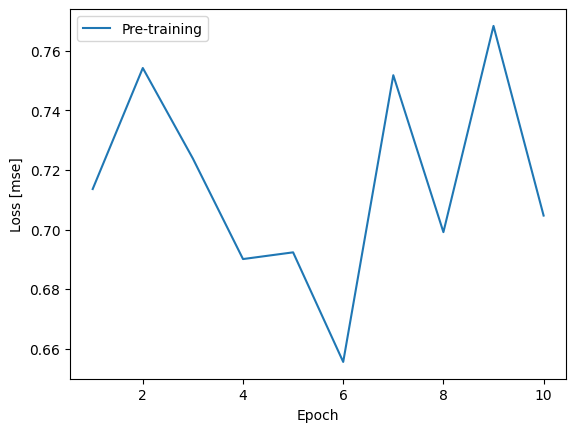

In [33]:
plt.plot(epochs, losses, label='Pre-training')
plt.ylim([min(plt.ylim()), max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [mse]')
plt.legend();

## Convert model to TensorFlow Lite format

Set of signatures that you use with the TensorFlow Lite model on a device: `train, infer, save, restore`.

In [34]:
SAVED_MODEL_DIR = "saved_model"

tf.saved_model.save(
    m,
    SAVED_MODEL_DIR,
    signatures={
        'train':
            m.train.get_concrete_function(),
        'infer':
            m.infer.get_concrete_function(),
        'save':
            m.save.get_concrete_function(),
        'restore':
            m.restore.get_concrete_function(),
    })

# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model(SAVED_MODEL_DIR)
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,  # enable TensorFlow Lite ops.
    tf.lite.OpsSet.SELECT_TF_OPS  # enable TensorFlow ops.
]
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

### Setup the TensorFlow Lite signatures

The TensorFlow Lite model saved in the previous step contains several function signatures, which can be accessed through the `tf.lite.Interpreter` class and invoke each `restore`, `train`, `save`, and `infer` signature separately.

0.0006292817465468316
RMSE: 0.012686912778234324
Plot tflite tcn final


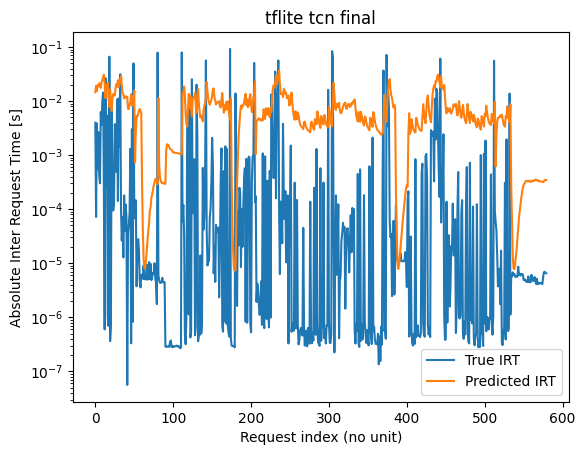

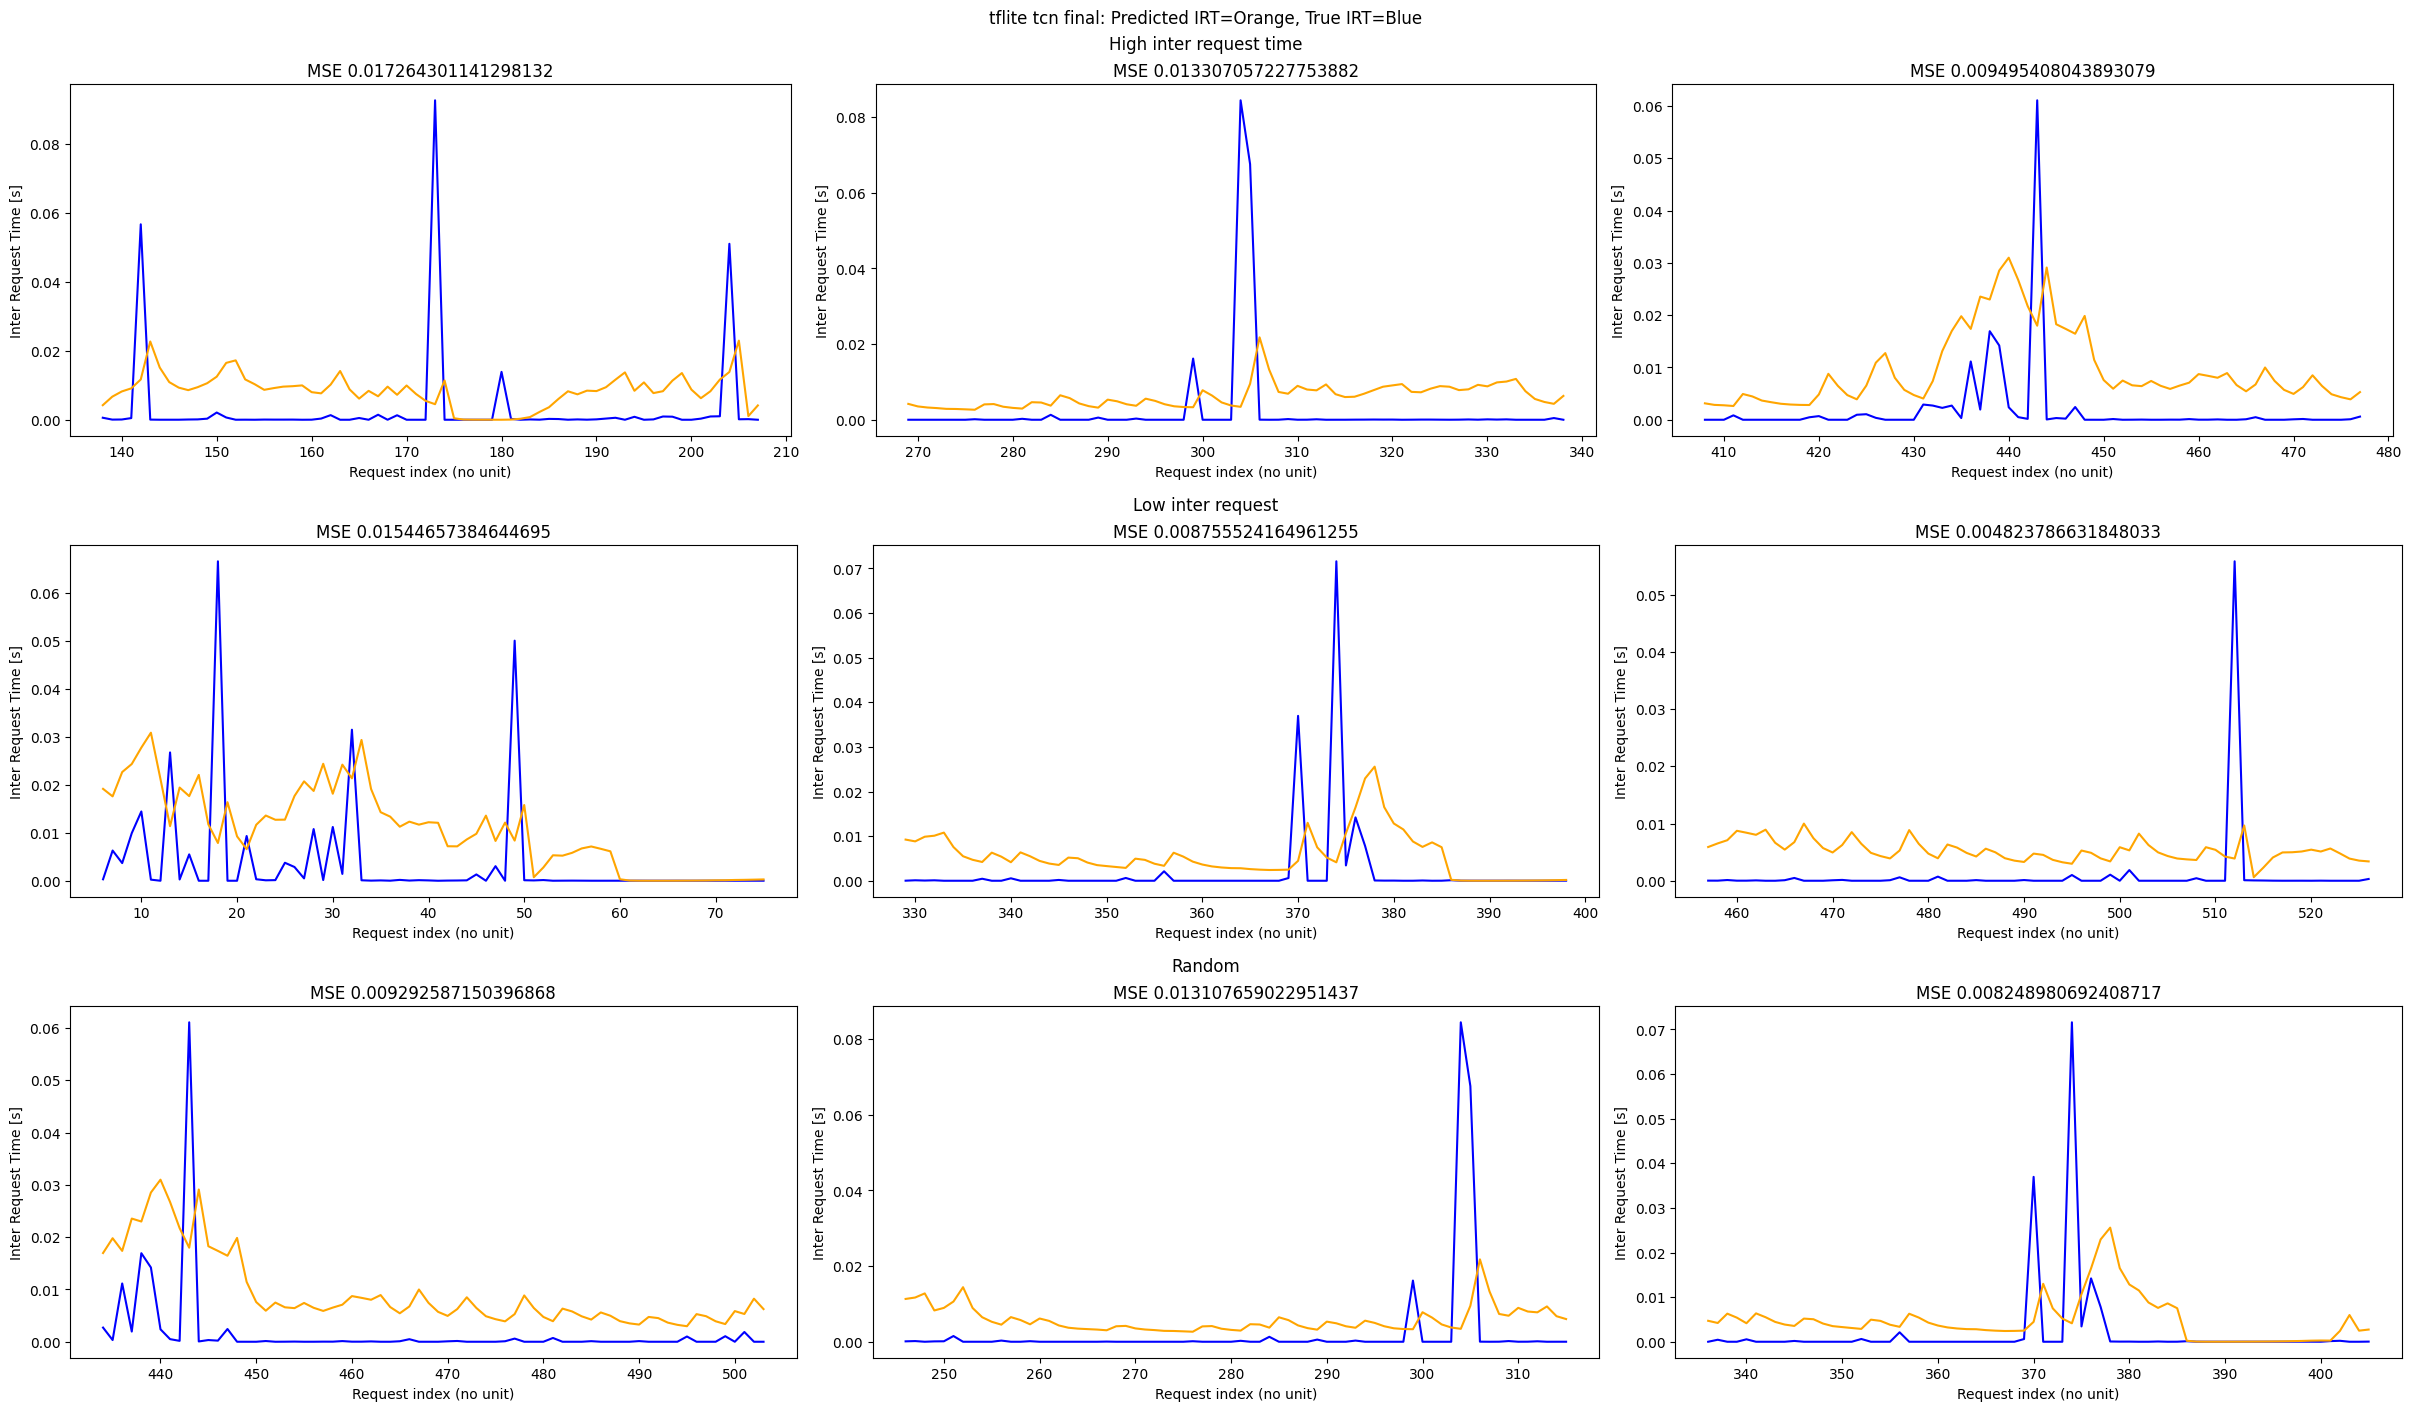

In [35]:
# Run the model with TensorFlow Lite
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

latencies = []
preds = []
for i in range(len(testX)):
  interpreter.set_tensor(input_details[0]["index"], testX[i:i+1])
  start = time.perf_counter()
  interpreter.invoke()
  latencies.append(time.perf_counter() - start)
  preds.append(interpreter.get_tensor(output_details[0]["index"]))

print(np.mean(latencies))
preds = np.array(preds).reshape(-1, 1)
y_pred = np.exp(inverse_scale(scaler, preds))
y_check = np.exp(inverse_scale(scaler, testY))
y_true = np.exp(df_test.iloc[n_past-1:-1]['future inter request time (s)'].to_numpy())
assert np.isclose(y_true,y_check, atol=1e-3).all() # check if y_true is really the target array
assert len(y_pred) == len(testX)
rmse = np.sqrt(mse(y_true, y_pred))
print(f"RMSE: {rmse}")
plot_predictions_detailed(y_true, y_pred, "", description = "tflite_tcn_final", show_plot=True)

## Online Training:


Run training for a few epochs to improve or personalize the model. In practice, you would run this additional training using data collected on the device. For simplicity, this example uses the same training data as the previous training step.

In [36]:
train = interpreter.get_signature_runner("train")

In [38]:
NUM_EPOCHS = 10
BATCH_SIZE = 1
more_epochs = np.arange(epochs[-1]+1, epochs[-1] + NUM_EPOCHS + 1, 1)
more_losses = np.zeros([NUM_EPOCHS])

for i in range(NUM_EPOCHS):
  for x,y in tqdm(train_ds):
    result = train(x=x, y=y)
  more_losses[i] = result['loss']
  if (i + 1) % 10 == 0:
    print(f"Finished {i+1} epochs")
    print(f"  loss: {more_losses[i]:.3f}")

100%|██████████| 380/380 [00:02<00:00, 133.78it/s]

Finished 10 epochs
  loss: 0.712


In [39]:
infer = interpreter.get_signature_runner("infer")
infer(x=testX[:1])

{'output_0': array([[0.7802276]], dtype=float32)}

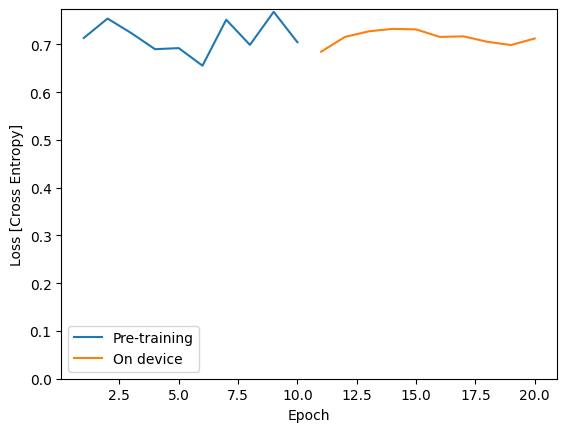

In [40]:
plt.plot(epochs, losses, label='Pre-training')
plt.plot(more_epochs, more_losses, label='On device')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [Cross Entropy]')
plt.legend();

## Save the trained weights

In [41]:
save = interpreter.get_signature_runner("save")

save(checkpoint_path=np.array("model.ckpt", dtype=np.string_))

{'checkpoint_path': array(b'model.ckpt', dtype=object)}